In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

In [19]:
country_data= pd.read_csv('Country-data.csv')
print(country_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB
None


In [20]:
print(country_data.isnull().sum()) ##Since there are no null alues we dont have any NAN values to remove

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64


In [21]:
country_data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


We will check if there are any duplicates on the basis of country to check if there are any double entries of any country; From the result it is clear that we dont have any duplicate entries

In [22]:
duplicates_in_one_column = len(country_data['country']) - len(country_data['country'].drop_duplicates())
print(f"Number of duplicates on the basis of country column: {duplicates_in_one_column}")

Number of duplicates on the basis of country column: 0


Now we will Stadardise the data

In [23]:
columns_to_normalize = country_data.select_dtypes(include=['float64', 'int64']).columns

In [24]:
train_X, test_X=train_test_split(country_data[columns_to_normalize],test_size=0.3, random_state=1)

In [25]:
scaler=StandardScaler()

In [26]:
scaler.fit(train_X)

StandardScaler()

In [27]:
train_X=scaler.transform(train_X)

In [28]:
test_X=scaler.transform(test_X)

In [29]:
train_X = pd.DataFrame(train_X, columns=columns_to_normalize)
test_X= pd.DataFrame(test_X, columns=columns_to_normalize)

Now, PCA(Principle Companant Analysis Technique) is applied to reduce the dimensionality of the data while retaining 90% of the varianceas it will help to simplify the complexity of the data and aided in visualization.

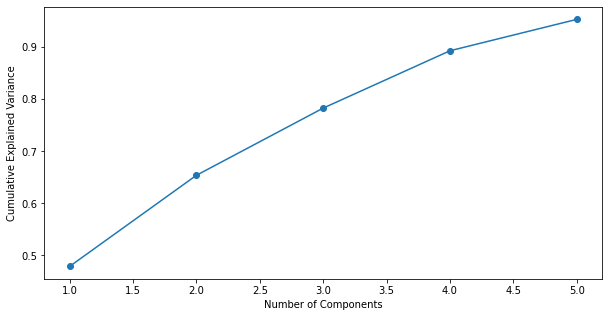

In [30]:
# Initialize PCA, retaining 90% of variance
pca = PCA(n_components=0.9)

# Fit and transform the normalized data
X_train_pca = pca.fit_transform(train_X)
X_test_pca = pca.transform(test_X)

# Plot the explained variance to understand the components
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()


I used K-mean Clustrering Elbow method to get most optimal number of clusters, according to which country will be labelled. I assumed the most optimal clusted as 4.

C:\Users\257380\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


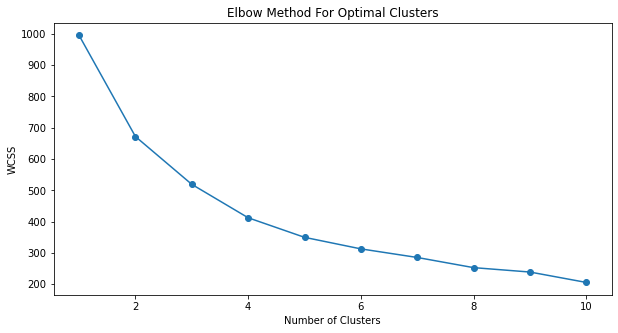

In [31]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_train_pca)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method For Optimal Clusters')
plt.show()

In [32]:
# Assuming the elbow method suggests 4 clusters

kmeans = KMeans(n_clusters=4, random_state=42)
train_clusters = kmeans.fit_predict(X_train_pca)
test_clusters = kmeans.predict(X_test_pca)

# Add the cluster labels to the original data
country_data.loc[train_X.index, 'Cluster'] = train_clusters
country_data.loc[test_X.index, 'Cluster'] = test_clusters


 Then,Hierarchical clustering is performed using ward linkage which provided a dendrogram that helped to visualize nested relationships between countries.

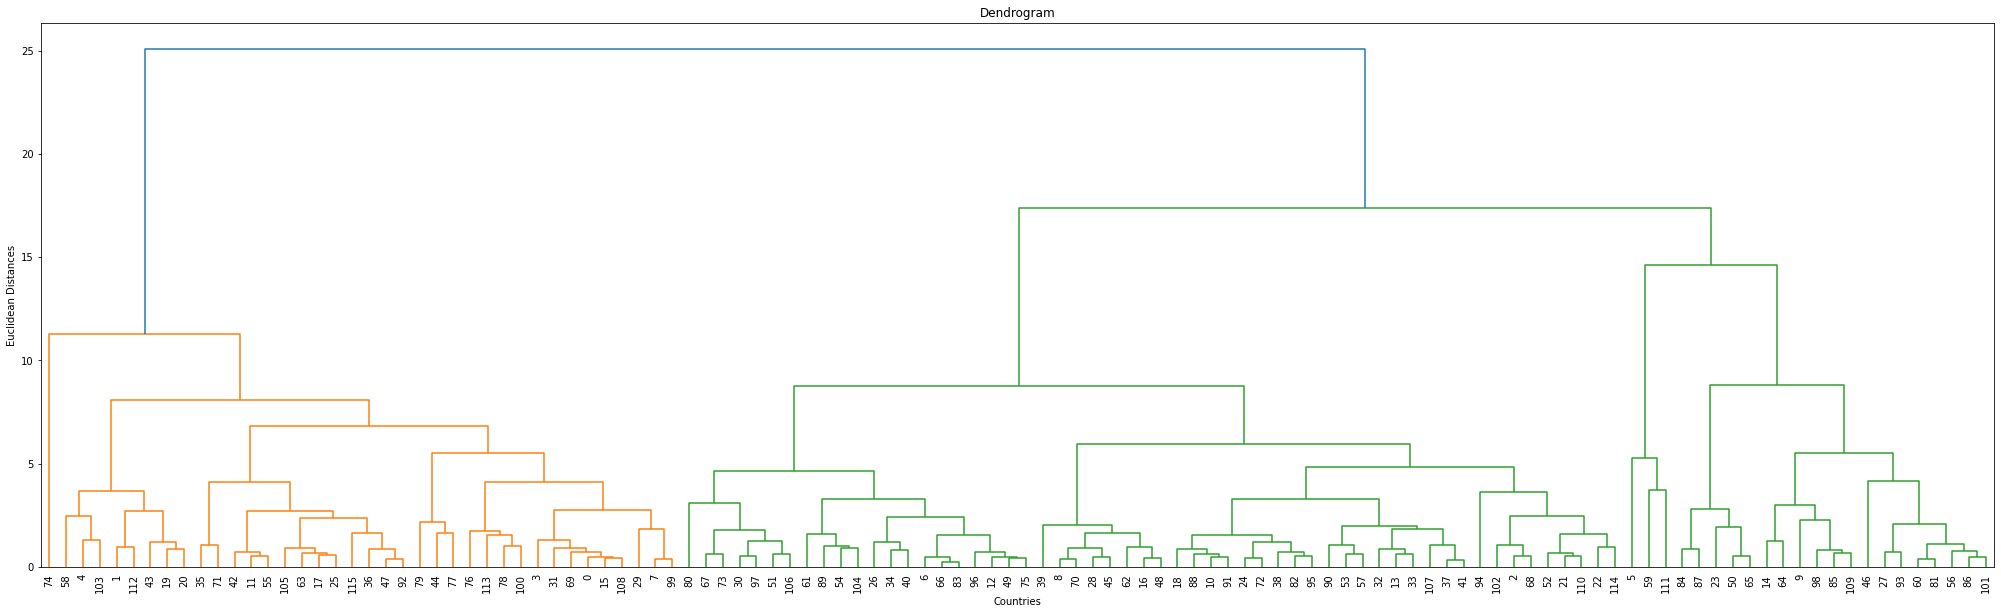

In [33]:
# Using 'ward' linkage to minimize variance within clusters
Z = linkage(X_train_pca, method='ward')

plt.figure(figsize=(35, 10))
dendrogram(Z, labels=train_X.index, leaf_rotation=90, leaf_font_size=10)
plt.title('Dendrogram')
plt.xlabel('Countries')
plt.ylabel('Euclidean Distances')
plt.show()


In [34]:
from sklearn.cluster import AgglomerativeClustering

# Fit Agglomerative Clustering
hc = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
train_hc_clusters = hc.fit_predict(X_train_pca)

# Predict clusters for test data
test_hc_clusters = hc.fit_predict(X_test_pca)

# Add the hierarchical cluster labels to the original data
country_data.loc[train_X.index, 'HC_Cluster'] = train_hc_clusters
country_data.loc[test_X.index, 'HC_Cluster'] = test_hc_clusters


Clusters have been summarized on the basis of mean values and accordingly cluster analysis can be done and through which indicators to be used for selection of countries is chosen.

In [36]:
# Summarize clusters
cluster_summary = country_data.groupby('Cluster').mean()
print(cluster_summary)

# Assuming lower GDP per capita, higher infant mortality, and lower life expectancy indicate higher need
priority_clusters = cluster_summary.sort_values(by=['gdpp', 'life_expec', 'child_mort'], ascending=[True, False, True])

# Extract countries in the highest priority cluster
priority_cluster_index = priority_clusters.index[0]
priority_countries = country_data[country_data['Cluster'] == priority_cluster_index]

print("Recommended Countries for Aid Allocation according to highest clusters that is Child Mortality(child_mort) ,GDP(gdpp) and\n Lower Life Expectancy(life_expec):")
print(priority_countries[['country', 'gdpp', 'life_expec', 'child_mort', 'Cluster']])


         child_mort    exports    health    imports        income  inflation  \
Cluster                                                                        
0.0       45.458621  38.016897  5.793448  42.451724  14382.896552  10.979379   
1.0       38.708333  42.750483  6.919167  47.247765  18897.050000   7.116533   
2.0       40.450000  29.900000  7.660000  36.950000  17680.000000  10.165000   
3.0       42.932000  40.175200  7.552800  54.508000  12959.440000   5.381160   

         life_expec  total_fer          gdpp  HC_Cluster  
Cluster                                                   
0.0       70.703448   3.217241  10571.827586    0.862069  
1.0       70.435000   2.851500  15242.150000    1.750000  
2.0       71.550000   3.220000  17505.000000    3.000000  
3.0       68.528000   3.032800   9500.680000    0.760000  
Recommended Countries for Aid Allocation according to highest clusters that is Child Mortality(child_mort) ,GDP(gdpp) and
 Lower Life Expectancy(life_expec):
       